인공지능 서비스 개발
- 일반적인 인공지능 서비스 개발 과정
1. 학습에 필요한 **데이터를 수집하고 가공**하기
2. 가공된 학습 데이터를 이용해 적절한 **인공지능 모델을 학습**
3. 학습된 **모델을 배포**하여 애플리케이션에서 이를 활용

전이학습(Transfer Learning)을 활용한 newjeans 분류기
- 개발 방법
1. python을 이용해 포털 사이트에서 **이미지를 크롤링**
2. **전이학습(Transfer Learning)**을 이용해 분류 모델을 학습
3. **Web API를 개방**하여 외부 프로그램이 해당 분류 모델을 이용

- 전이학습이란
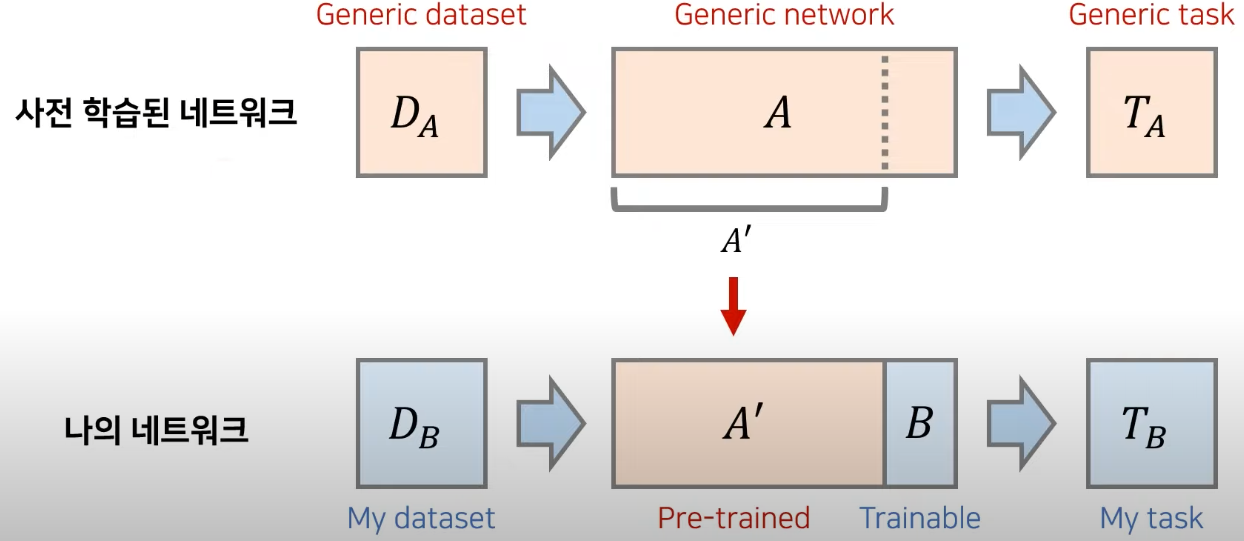

  - 사전 학습된 네트워크
    - 방대한 양의 데이터로 학습되어 각각의 클래스로 분류 가능
    - 이미지가 주어지면 적절한 특징을 추출하여 분류
      - 네트워크의 앞부분을 잘라서 사용하면 특징 추출기로 이용 가능
  - 나의 네트워크
    - 사전 학습된 네트워크에서 특징 추출기(한 장의 이미지에서 적절한 특징을 추출할 수 있는 학습이 되어있다)를 잘라와 뒤쪽에 학습 가능한 파라미터를 붙임
    - 우리가 원하는 task를 수행하는 분류기가 생성됨
    - 사전 학습된 네트워크를 이용하여 학습시간을 줄이고 적은 양의 데이터로만으로도 높은 정확도 가능 

서비스 구성도
1. 전이학습을 통해 파이토치 모델 구성
2.  Flask 서버로 web api 개방(개인은 별도의 공인 ip가 없기 때문에 Ngrok을 통해 별도의 공인 ip를 부여받아 서버를 개방할 수 있다)
3. 전세계에서 api를 통해 서비스를 사용 가능

# 1. 데이터 수집 / 정제

In [6]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

# 데이터 시각화를 위해 그래프나 도형을 화면에 출력해줌
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# plt.rcParams['font.family'] = 'NanumBarunGothic.ttf'
# plt.rc('font', family='NanumBarunGothic')

# plt.title('한글 제목')
# plt.show()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,222 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 128208 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


In [8]:
# 이미지 다운로드 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 86 (delta 17), reused 10 (delta 10), pack-reused 64
Unpacking objects: 100% (86/86), 17.48 KiB | 994.00 KiB/s, done.


## 1. 이미지 크롤링을 활용하여 데이터 수집
  - 수집한 데이터를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의

In [9]:
# 디렉토리를 만들기 위해 os 모듈 사용
import os
# 파일 및 디렉토리 작업을 수행(복사, 이동, 이름 바꾸기, 생성, 삭제)하기 위한 함수를 제공
import shutil # shutil == shell utility
# 데이터를 수집하기 위해 이미지 다운로더를 사용
from bing_image_downloader.bing_image_downloader import downloader

# 디렉토리 경로를 저장한 변수
directory_list = [
    # 학습 데이터를 저장할 디렉토리 경로
    './newjeans_dataset/train/',
    # 평가 데이터를 저장할 디렉토리 경로
    './newjeans_dataset/test/',
]

# 초기 디렉토리 만들기
# directory_list를 순회하면서
for directory in directory_list:
    # os.path.isdir()를 사용하여 해당 디렉토리가 할당된 경로가 아니라면
    if not os.path.isdir(directory):
        # os.makedirs()를 사용하여 디렉토리를 생성
        os.makedirs(directory)

# 데이터를 수집하고 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):  # query 검색어 / train_cnt train에 넣어줄 data의 개수 (나머지는 test로 넣음)
    # directory_list를 순회하면서
    for directory in directory_list:
        # 해당 디렉토리 내에 query(이미지 검색 결과) 이름을 갖는 디렉토리가 없다면
        if not os.path.isdir(directory + '/' + query):
            # query(이미지 검색 결과) 이름을 갖는 디렉토리를 생성한다
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비
    cnt = 0   # 데이터를 셀 변수
    # query에서 지정한 경로에 있는 모든 파일을 가져와서 반복한다
    for file_name in os.listdir(query):
        # train_cnt 개수보다 cnt가 작다면 데이터 파일을 train 디렉토리로 이동
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './newjeans_dataset/train/' + query + '/' + file_name)
        # train_cnt 개수보다 cnt가 크다면 데이터 파일을 test 디렉토리로 이동
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './newjeans_dataset/test/' + query + '/' + file_name)
        # 데이터의 수 1 추가
        cnt += 1
    # rmtree 함수를 사용하여 query 변수에서 지정한 경로를 삭제(해당 경로에 있는 모든 파일과 디렉토리를 제거)
    shutil.rmtree(query)

### 뉴진스 멤버를 검색하여 데이터 저장하기

In [10]:
# 검색어 입력
query = 'newjeans hanni'
# bing downloader를 이용하여 데이터 저장(query == 검색어, limit= 다운받을 데이터의 수,  output_dir==데이터를 저장할 디렉토리 경로, adult_filter_off==검색결과 필터, force_replace==이미지가 이미 존재할 경우 덮어쓸지 여부, timeout==다운로드 타임아웃 시간 (초))
downloader.download(query, limit=60,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
# 데이터를 수집하고 학습 데이터와 평가 데이터로 구분하는 함수를 통해 데이터 생성(qeury = 검색어, 숫자 = 데이터 숫자)
dataset_split(query, 50)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://www.allkpop.com/upload/2022/08/content/111542/1660246936-image.png)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://i.pinimg.com/originals/4b/38/82/4b3882be2e2e2f09be8cd38de6789bd7.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://i.ytimg.com/vi/qSJ3PWnyomw/maxresdefault.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://kpopping.com/documents/46/1/1600/220804-NewJeans-Hanni-Cookie-at-M-Countdown-documents-5.jpeg?v=22225)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://i0.wp.com/kstartrend.com/wp-content/uploads/2022/09/image-1.png?resize=1024%2C1536&amp;ssl=1)
[Info] Issue getting: https://i0.wp.com/kstartrend.com/wp-content/uploads/2022/09/image-1.png?resize=1024%2C1536&amp;ssl=1
[Error] HTTP Error 404: Not Found
#5 이미지 다운로드 (https://kpopping.com/documents/88/1/1600/220804-NewJeans-Hanni-Hype-Boy-at-M-Countdown-documents-8.jpeg?v=22225)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://cdn.kbizoom.com/media/2022/08/13121349/hanni-

In [11]:
query = 'newjeans minji'
downloader.download(query, limit=60,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 50)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://www.allkpop.com/upload/2022/08/content/261302/1661533332-image.png)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://kpopping.com/documents/5e/4/1600/220804-NewJeans-Minji-Cookie-at-M-Countdown-documents-1.jpeg?v=22225)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://1409791524.rsc.cdn77.org/data/images/full/621512/newjeans-minji-almost-debuted-in-sm-entertainment-heres-why-it-didnt-happen.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://lh3.googleusercontent.com/LAcfQAqTYFcWw0Ug6zkgizmWUP5MvfJ7yMjK9Dq81x-Oeue53AWvLb7ccQRCn6_Ok9xof9kDz9m3Zvr_f7nQAWH-KdAKQvpnf0OPQuiSFvQQnD1Z=w960-rj-nu-e365)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Minji_(NewJeans)_220812.jpg/1200px-Minji_(NewJeans)_220812.jpg)
[Error] Invalid image, not saving https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Minji_(NewJeans)_220812.jpg/1200px-Minji_(NewJeans)_220812.jpg
[Info] Issue getting: htt

In [12]:
query = 'newjeans daniel'
downloader.download(query, limit=60,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 50)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://www.allkpop.com/upload/2022/08/content/041255/web_data/allkpop_1659632235_untitled-1.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://i.postimg.cc/Y2W1NzgS/New-Jeans-Danielle.jpg)
[Error] Invalid image, not saving https://i.postimg.cc/Y2W1NzgS/New-Jeans-Danielle.jpg
[Info] Issue getting: https://i.postimg.cc/Y2W1NzgS/New-Jeans-Danielle.jpg
[Error] No active exception to reraise
#2 이미지 다운로드 (https://image.kpopmap.com/2022/07/NewJeans-Danielle-072722-1.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://i.pinimg.com/originals/7c/64/b6/7c64b61f670cd97ac9993c1ae4a24543.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://1409791524.rsc.cdn77.org/data/images/full/620742/newjeans-danielle-shocking-pre-debut-life-revealed.png)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://i.pinimg.com/736x/dc/84/2f/dc842fc58dcc03b5b2000191af1d2fe7.jpg)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://channel-korea.com/wp-content/uploads/2022/08/Danielle

In [13]:
query = 'newjeans haerin'
downloader.download(query, limit=60,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 50)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://kpopping.com/documents/6a/4/2520/220802-NewJeans-Haerin-Chanel-Pop-Up-Store-Event-documents-1.jpeg?v=40675)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://lh3.googleusercontent.com/tVcdk6gIye_KC_Rrz8BLMQqvPnTvvKRXYi0JxHsxRz0HGOLAFE5P4IE3-WSbpBFjhbTn3ORouN6jKJk48iaOvHW_KRMfu0Bk07Ey8vxr3w7HRbS0=w960-rj-nu-e365)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://i.pinimg.com/736x/32/65/4e/32654ef7a37861f698e27ef36019076c.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://1409791524.rsc.cdn77.org/data/images/full/619637/newjeans-haerin.jpg?w=600?w=650)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (https://www.allkpop.com/upload/2022/07/content/231419/web_data/allkpop_1658600622_thumbnail-2.jpg)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://www.allkpop.com/upload/2022/09/content/120925/1662989123-image.png)
#6 파일 다운로드가 완료되었습니다.
#7 이미지 다운로드 (https://kpopping.com/documents/56/1/1000/220812-HAERIN-NEW-JEANS-documents-4.jpeg?v=9834a)
#7 파일 다운로드가 완료

In [14]:
query = 'newjeans hyein'
downloader.download(query, limit=60,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 50)

[Info] Indexing page: 1
[Info] Indexed 35 Images on Page 1.
#1 이미지 다운로드 (https://dbkpop.com/wp-content/uploads/2022/07/newjeans_debut_teaser_2_Hyein.jpg)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://channel-korea.com/wp-content/uploads/2022/08/NEWJEANS-Hyein.jpeg)
[Info] Issue getting: https://channel-korea.com/wp-content/uploads/2022/08/NEWJEANS-Hyein.jpeg
[Error] <urlopen error [SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1131)>
#2 이미지 다운로드 (https://i.pinimg.com/originals/28/e2/30/28e230975a868b55471fb0274a05a14d.jpg)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (https://channel-korea.com/wp-content/uploads/2022/08/NEWJEANS-Hyein-2.jpg)
[Info] Issue getting: https://channel-korea.com/wp-content/uploads/2022/08/NEWJEANS-Hyein-2.jpg
[Error] <urlopen error [SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1131)>
#3 이미지 다운로드 (https://i.pinimg.com/originals/e3/6c/bb/e36cbb0224395b74cd55a21202fc4050.jpg)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (https://i.pinimg.com/originals/fa/52/10/fa521025

## 2. PyTorch를 이용한 전이 학습(Transfer Learning)
  - 학습을 위해 필요한 라이브러리 불러오기

In [15]:
# 파이토치의 핵심 패키지(모델 구성 및 학습 등을 수행할 수 있는 기능을 제공)
import torch
# PyTorch에서 제공하는 신경망 모듈
import torch.nn as nn
# 학습에 사용되는 최적화 알고리즘
import torch.optim as optim
# PyTorch에서 이미지 데이터 처리와 관련된 함수와 모델들을 제공
import torchvision
# transforms 모듈은 데이터 전처리를 위한 함수들을 제공
from torchvision import datasets, models, transforms
# 다차원 배열을 다루는데 사용
import numpy as np
# 시간과 관련된 함수를 제공
import time

# GPU가 사용 가능한 경우 cuda를 0으로 초기화하여 사용 / GPU가 사용 불가능한 경우 CPU로 초기화하여 CPU 사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

  - 데이터 불러오기

In [16]:
# 데이터 전처리를 통해 데이터 가공을 하여 모델의 성능을 강화

# 학습데이터를 불러올 때
transforms_train = transforms.Compose([
    # 해상도를 (224,224)로 맞춰준다
    transforms.Resize((224, 224)),
    # 이미지를 좌우로 뒤집어서 데이터 증강(augmentation)을 수행(확률을 높여준)
    transforms.RandomHorizontalFlip(),
    # 이미지를 PyTorch의 Tensor로 변환
    transforms.ToTensor(),
    # 이미지의 RGB 채널 값을 평균과 표준편차를 이용하여 정규화
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

#  테스트데이터를 불러올 때
transforms_test = transforms.Compose([
    # 해상도를 (224,224)로 맞춰준다
    transforms.Resize((224, 224)),
    # 이미지를 PyTorch의 Tensor로 변환
    transforms.ToTensor(),
    # 이미지의 RGB 채널 값을 평균과 표준편차를 이용하여 정규화
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터가 저장된 경로
data_dir = './newjeans_dataset'
# 데이터가 저장된 경로에서 ImageFolder를 이용하여 이미지 데이터셋을 전처리한 후 로드(transforms_*==전처리 수행)
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)
# DataLoader를 이용하여 데이터셋에서 미니배치(minibatch)를 추출 (batch_size==미니배치의 크기 / shuffle==데이터셋을 섞을지 여부 / num_workers==데이터셋을 불러올 때 사용할 프로세스 수)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=5, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=5, shuffle=True, num_workers=4)
# 수행 결과를 출력
print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))
# 학습된 클래스 이름과 수행 결과를 출력
class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 250
테스트 데이터셋 크기: 50
클래스: ['newjeans daniel', 'newjeans haerin', 'newjeans hanni', 'newjeans hyein', 'newjeans minji']


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  - 이미지 시각화

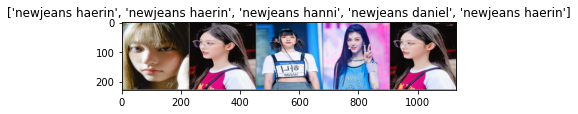

In [17]:
def imshow(input, title):
    # 이미지로 변환해주는 matplotlib(ply)는 numpy 객체만 받을 수 있기 때문에 torch.Tensor를 numpy 객체로 변환
    # pytorh는 (채널, 높이, 너비)의 순서를 갖기 때문에 transpose((1, 2, 0))를 통해 (높이, 너비, 채널)로 순서를 바꿔준다
    input = input.numpy().transpose((1, 2, 0))
    # 데이터셋에서 계산된 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # 정규화된 이미지 데이터에 평균을 더하고 표준편차를 곱하여 정규화를 해제
    input = std * input + mean
    # 이미지 데이터의 픽셀 값이 0보다 작거나 1보다 클 경우, 0 또는 1로 대체
    input = np.clip(input, 0, 1)
    # matplotlib를 이용하여 이미지 데이터를 출력
    plt.imshow(input)
    # 이미지의 타이틀을 설정
    plt.title(title)
    # 이미지를 보여줌
    plt.show()


# train_dataloader(학습 데이터)를 iterator(배치 단위)로 불러오기
iterator = iter(train_dataloader)

# iterator에서 배치 불러오기
inputs, classes = next(iterator)
# 입력 이미지를 격자 형태로 만들기
out = torchvision.utils.make_grid(inputs)
# imshow==정규화를 해제하고 이미지를 시각화 / title==현재 배치의 정답 클래스
imshow(out, title=[class_names[x] for x in classes])

  - 학습할 CNN 딥러닝 모델 객체를 초기화

In [18]:
# 미리 학습된 ResNet-34 모델 네트워크 불러오기
model = models.resnet34(pretrained=True)
# 불러온 네트워크 모델의 출력 뉴런 수를 저장
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 5개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 5)
# GPU를 사용하기 위해 모델을 CUDA 디바이스로 보냅니다.
model = model.to(device)
# Cross Entropy Loss(분류 문제에서 주로 사용되는 손실 함수) 불러오기
criterion = nn.CrossEntropyLoss()
# Stochastic Gradient Descent(SGD) 최적화 함수를 불러온 후, 학습률(learning rate)과 모멘텀(momentum) 값을 설정합니다.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

  - 학습 진행하기

In [19]:
# 전체 학습 과정을 몇 번 반복할지를 정하기
num_epochs = 50
# 모델을 학습모드로 설정
model.train()
# 현재 시간을 저장
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    # 현재까지 누적된 손실 값
    running_loss = 0.
    # 현재까지 맞춘 총 이미지 개수
    running_corrects = 0

    # 배치 단위로 나눈 학습 데이터 순회하며 불러와서
    for inputs, labels in train_dataloader:
        # 입력 이미지 데이터 / GPU를 사용하기 위해 .to(device) 메소드를 사용
        inputs = inputs.to(device)
        # 해당 이미지의 정답 라벨
        labels = labels.to(device)

        # 학습이 이루어지는 부분
        # 학습을 하기 전에 이전 학습에서 계산된 gradient 값을 0으로 초기화
        optimizer.zero_grad()
        # 모델에 학습 데이터를 입력 (forward propagation이 이루어지며, 모델은 입력을 받아 출력값을 계산)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # 모델이 예측한 출력값 outputs와 실제 정답인 라벨 labels를 비교하여 손실 값을 계산
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        # 손실 값의 gradient를 계산(backward propagation이 이루어지며, 손실 함수를 모델의 출력값으로 미분한 gradient 값을 계산)
        loss.backward()
        # optimization - 계산된 gradient 값을 이용하여 모델의 파라미터를 업데이트
        optimizer.step()

        # 이번 배치에서 계산된 손실 값과 정확도를 running_loss와 running_corrects 변수에 더함
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # 모든 배치에서 계산된 손실 값과 정확도를 이용하여 epoch 단위로 평균 손실 값과 정확도를 계산
    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 1.5859 Acc: 31.2000% Time: 17.5670s
#1 Loss: 0.7643 Acc: 72.8000% Time: 29.4908s
#2 Loss: 0.5264 Acc: 81.2000% Time: 42.8379s
#3 Loss: 0.2891 Acc: 92.0000% Time: 54.7813s
#4 Loss: 0.1838 Acc: 94.4000% Time: 66.7114s
#5 Loss: 0.2377 Acc: 92.8000% Time: 78.5949s
#6 Loss: 0.2542 Acc: 90.8000% Time: 89.9376s
#7 Loss: 0.1403 Acc: 96.4000% Time: 100.8480s
#8 Loss: 0.2078 Acc: 93.2000% Time: 112.6156s
#9 Loss: 0.2118 Acc: 92.8000% Time: 124.7065s
#10 Loss: 0.2062 Acc: 92.8000% Time: 136.7259s
#11 Loss: 0.2108 Acc: 91.2000% Time: 148.7228s
#12 Loss: 0.1401 Acc: 95.2000% Time: 160.6529s
#13 Loss: 0.1822 Acc: 93.6000% Time: 172.5297s
#14 Loss: 0.1880 Acc: 93.2000% Time: 184.1877s
#15 Loss: 0.1796 Acc: 94.0000% Time: 194.8878s
#16 Loss: 0.2607 Acc: 91.6000% Time: 207.9976s
#17 Loss: 0.1245 Acc: 96.0000% Time: 219.9959s
#18 Loss: 0.0513 Acc: 98.0000% Time: 231.8665s
#19 Loss: 0.0692 Acc: 98.0000% Time: 243.7768s
#20 Loss: 0.0801 Acc: 97.2000% Time: 255.6810s
#21 Loss: 0.0472 Acc: 99.2000%

  - 학습된 모델 평가하기

[예측 결과: newjeans daniel] (실제 정답: newjeans daniel)


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


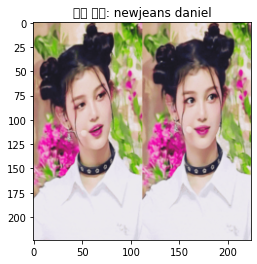

[예측 결과: newjeans haerin] (실제 정답: newjeans haerin)


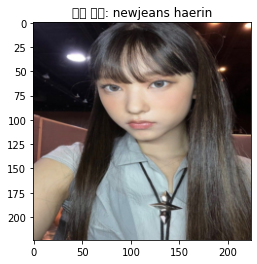

[예측 결과: newjeans hyein] (실제 정답: newjeans hyein)


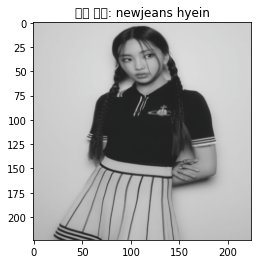

[예측 결과: newjeans minji] (실제 정답: newjeans minji)


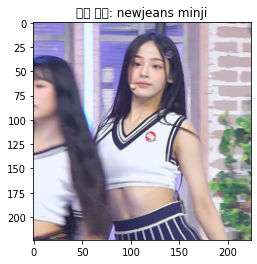

[예측 결과: newjeans minji] (실제 정답: newjeans minji)


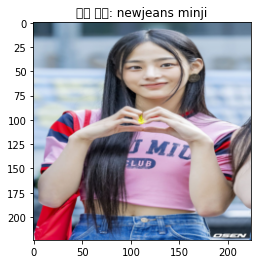

[예측 결과: newjeans hanni] (실제 정답: newjeans hanni)


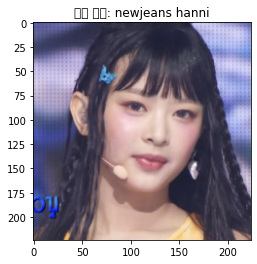

[예측 결과: newjeans hanni] (실제 정답: newjeans hanni)


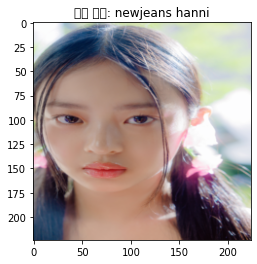

[예측 결과: newjeans haerin] (실제 정답: newjeans haerin)


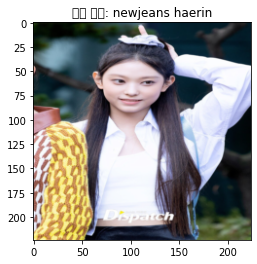

[예측 결과: newjeans minji] (실제 정답: newjeans minji)


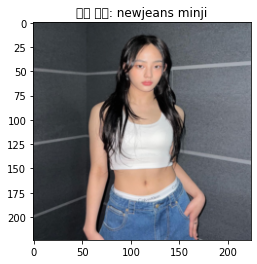

[예측 결과: newjeans hanni] (실제 정답: newjeans hanni)


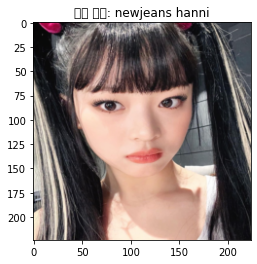

[Test Phase] Loss: 0.1601 Acc: 96.0000% Time: 3.5733s


In [20]:
# 모델을 평가 모드로 설정
model.eval()
# 현재 시간을 저장
start_time = time.time()

# PyTorch의 연산 그래프에서 이전 계산에서 계산한 gradient를 기록하지 않고 연산을 수행하는 context 
# 테스트 단계에서 모델의 평가를 수행할 때 사용
with torch.no_grad():
    # 각각 전체 loss와 정확도를 누적하는 변수
    # 테스트 데이터셋의 모든 배치를 순회하면서 모델의 예측과 정답을 비교하여 loss와 정확도를 누적
    running_loss = 0.
    running_corrects = 0
    
    # 배치 단위로 나눈 학습 데이터 순회하며 불러와서
    for inputs, labels in test_dataloader:
        # 입력 이미지 데이터 / GPU를 사용하기 위해 .to(device) 메소드를 사용
        inputs = inputs.to(device)
        # 해당 이미지의 정답 라벨
        labels = labels.to(device)

        # 모델에 학습 데이터를 입력 (forward propagation이 이루어지며, 모델은 입력을 받아 출력값을 계산)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # 모델이 예측한 출력값 outputs와 실제 정답인 라벨 labels를 비교하여 손실 값을 계산
        loss = criterion(outputs, labels)

        # 이번 배치에서 계산된 손실 값과 정확도를 running_loss와 running_corrects 변수에 더함
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 이미지의 예측결과와 실제 정답을 출력
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # 해당 이미지를 출력하고 예측결과를 같이 보여줌
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
    
    # 모든 배치에서 계산된 손실 값과 정확도를 이용하여 epoch 단위로 평균 손실 값과 정확도를 계산
    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    # 테스트 과정 중에 결과 출력
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

## 3. 분류 모델 API
  - 학습된 분류 모델을 다른 사람이 사용할 수 있도록 API 배포
  - 이미지를 파일로부터 읽어와 분류 결과를 반환

In [27]:
# 분류하기 위한 이미지 다운로드하기
!wget https://i.ytimg.com/vi/OtvMV4q9hSw/maxresdefault.jpg -O test_image.jpg

--2023-02-26 08:57:58--  https://i.ytimg.com/vi/OtvMV4q9hSw/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 64.233.170.119, 74.125.68.119, 74.125.24.119, ...
Connecting to i.ytimg.com (i.ytimg.com)|64.233.170.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117719 (115K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>] 114.96K  --.-KB/s    in 0.001s  

2023-02-26 08:57:59 (128 MB/s) - ‘test_image.jpg’ saved [117719/117719]



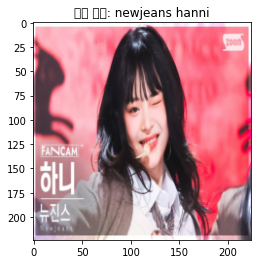

In [28]:
from PIL import Image
# 분류를 위한 이미지를 열어서 image로 저장
image = Image.open('test_image.jpg')
# 저장한 이미지를 전처리(unsqueeze를 이용해 배치 차원을 추가하고, GPU를 사용)
image = transforms_test(image).unsqueeze(0).to(device)

# 모델의 파라미터가 업데이트 되지 않고 연산의 중복을 막아 빠른 결과를 출력
with torch.no_grad():
    # model에 image를 넣어 예측
    outputs = model(image)
    # torch.max 함수를 이용해 출력값 중 가장 큰 값을 가지는 인덱스
    _, preds = torch.max(outputs, 1)
    # 이미지와 예측 결과를 함께 시각화
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

  - 웹 API 개방을 위해 Ngrok 사용
  - API 기능 제공을 위해 Flask 사용

In [29]:
# 필요한 라이브러리 설치하기
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# 파일 읽기 쓰기를 위한 모듈
import io
# 개발한 서버를 외부에서 접근할 수 있도록 해줌 / 공개적인 url을 생성하고 서버에 접근 가능
from flask_ngrok import run_with_ngrok
# Flask==웹서버 구축 / jsonify== JSON으로 데이터 반환 / request==HTTP요청에 액세스
from flask import Flask, jsonify, request

# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    # 이미지 바이트 데이터를 입력으로 받아 image에 저장
    image = Image.open(io.BytesIO(image_bytes))
    # 저장한 이미지를 전처리(unsqueeze를 이용해 배치 차원을 추가하고, GPU를 사용)
    image = transforms_test(image).unsqueeze(0).to(device)

    # 모델의 파라미터가 업데이트 되지 않고 연산의 중복을 막아 빠른 결과를 출력
    with torch.no_grad():
        # model에 image를 넣어 예측
        outputs = model(image)
        # torch.max 함수를 이용해 출력값 중 가장 큰 값을 가지는 인덱스
        _, preds = torch.max(outputs, 1)
        # 이미지와 예측 결과를 함께 시각화
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])
    # 예측한 결과 preds에서 가장 확률이 높은 클래스를 class_names 리스트에서 찾아 반환
    return class_names[preds[0]]

# Flask 객체 초기화
app = Flask(__name__)

# post 방식으로 root 경로에 파일이 요청이 온 경우
@app.route('/', methods=['POST'])
def predict():
    # POST 요청이 왔을 때
    if request.method == 'POST':
        # 도착한 이미지 바이트 데이터 file로 저장
        file = request.files['file']
        # 파일을 읽어서 image_bytes로 저장
        image_bytes = file.read()

        # image_bytes를 get_prediction를 통해 분류
        class_name = get_prediction(image_bytes=image_bytes)
        # 결과 출력
        print("결과:", {'class_name': class_name})
        # 클라이언트에게 json 형태로 돌려줌
        return jsonify({'class_name': class_name})

   - 무료 Ngrok 서비스로 실행할 때마다 주소가 변경될 수 있다
   - 서버 주소를 정확히 확인해야 한다

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://8c60-35-240-248-145.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
 * Running on http://8c60-35-240-248-145.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
 * Running on http://8c60-35-240-248-145.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


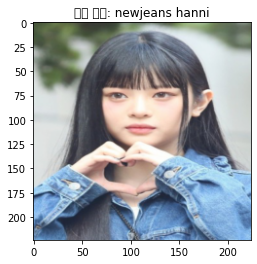

INFO:werkzeug:127.0.0.1 - - [26/Feb/2023 09:59:24] "POST / HTTP/1.1" 200 -


결과: {'class_name': 'newjeans hanni'}


In [ ]:
# Flask 애플리케이션을 Ngrok URL로 공개
run_with_ngrok(app)
# Flask 애플리케이션을 실행하는 함수(run_with_ngrok(app) 함수를 통해 Ngrok을 통해 URL을 만들어 놓았기 때문에, 로컬 서버 대신 Ngrok URL로부터 요청을 받아 처리)
app.run()

  - 클라이언트 테스트
    - curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}
  - 사용법
    1. cmd를 열어 이미지가 존재하는 폴더로 이동
    2. curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}로 이미지 보내기